#Carga de datos

In [2]:
# Cargar fichero labels
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dengue_labels_train.csv to dengue_labels_train.csv
User uploaded file "dengue_labels_train.csv" with length 19582 bytes


In [3]:
# 0. load data in DataFrame
import pandas as pd
import io
denguelabels = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
denguelabels.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [4]:
uploaded1 = files.upload()

for fn1 in uploaded1.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn1, length=len(uploaded1[fn1])))

Saving dengue_features_train.csv to dengue_features_train.csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes


In [5]:
# Cargar fichero train
import pandas as pd
import io
denguetrain = pd.read_csv(io.StringIO(uploaded1[fn1].decode('utf-8')))
denguetrain.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [6]:
# Cargar fichero test
uploaded2 = files.upload()

for fn2 in uploaded2.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn2, length=len(uploaded2[fn2])))

Saving dengue_features_test.csv to dengue_features_test.csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes


In [ ]:
# Cargar fichero test
import pandas as pd
import io
denguetest = pd.read_csv(io.StringIO(uploaded2[fn2].decode('utf-8')))
denguetest.fillna(denguetest.mean(), inplace=True)
denguetest.set_index(['city','year','weekofyear'])
del denguetest['week_start_date']

In [ ]:
denguejoined = pd.merge(denguetrain, denguelabels, left_index=True, right_index=True,on=['city','year','weekofyear'])

# Selección de variables

In [11]:
denguejoined

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1


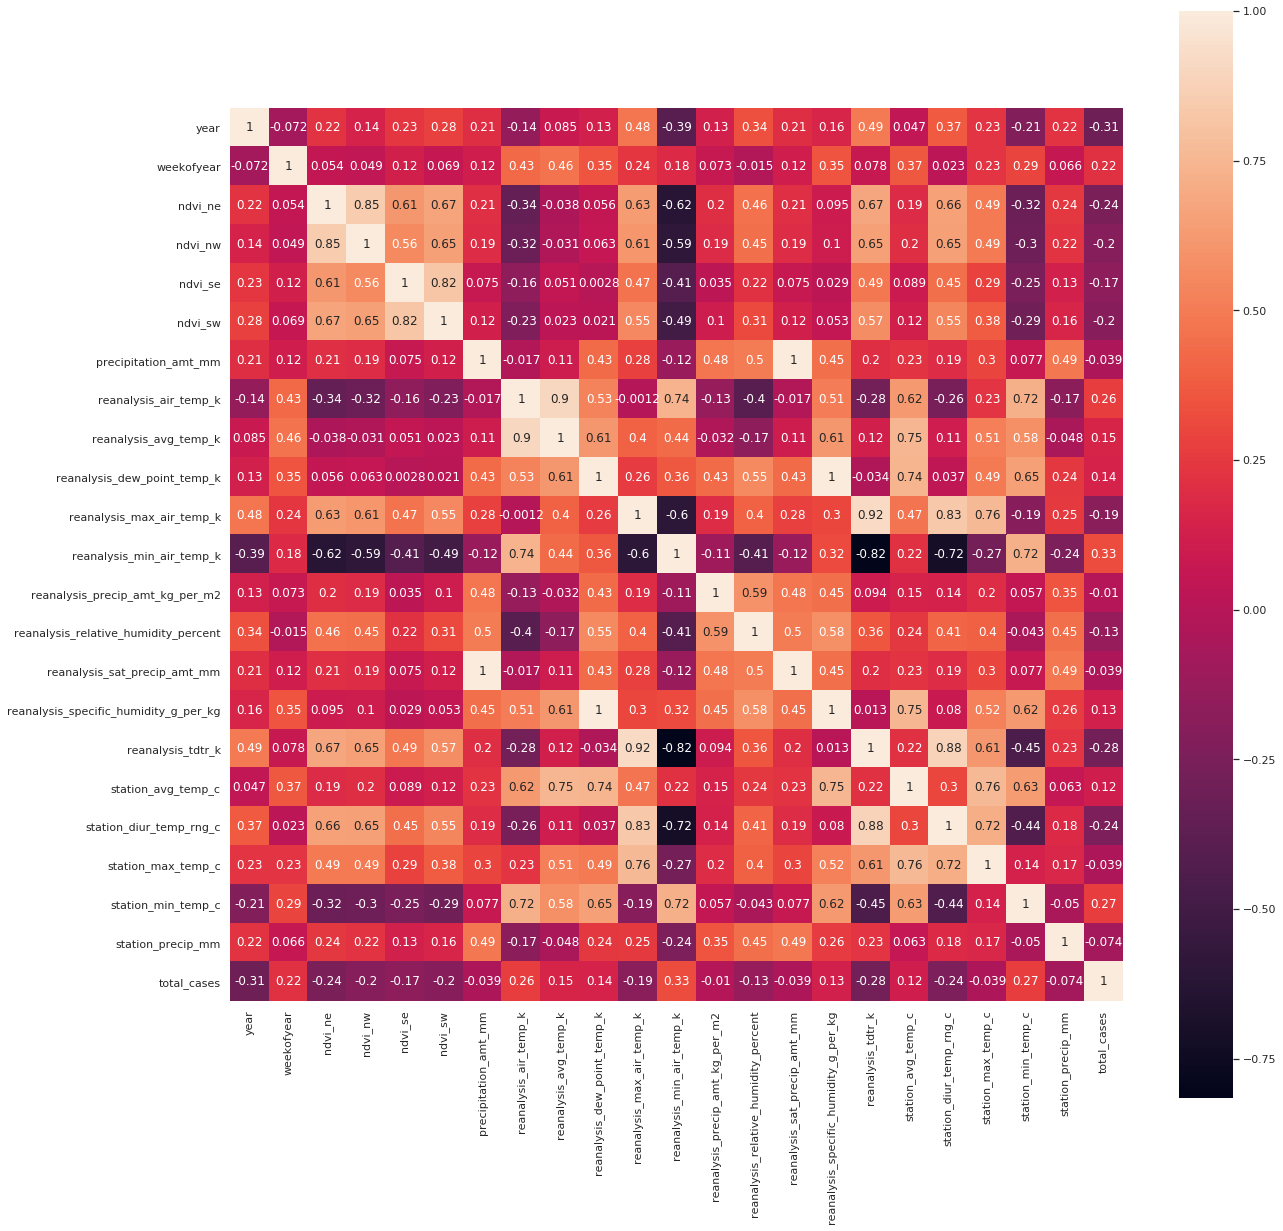

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
fig, ax = plt.subplots(figsize=(20,20))  
sns.heatmap(denguejoined.corr(), square=True, annot=True,ax=ax)

In [13]:
# 0.1 features and labels
df = denguejoined[['reanalysis_min_air_temp_k', 'station_min_temp_c','reanalysis_air_temp_k','weekofyear','year','reanalysis_tdtr_k','station_diur_temp_rng_c','ndvi_ne', 'total_cases']]
df.reset_index(drop = True, inplace = True)
df['NanInRowCount']=df.isnull().sum(axis=1)
df = df.drop(df[df.NanInRowCount > 10].index)
df = df.drop(['NanInRowCount'], axis=1) 
df = df.interpolate(method ='linear', axis=0)
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,reanalysis_min_air_temp_k,station_min_temp_c,reanalysis_air_temp_k,weekofyear,year,reanalysis_tdtr_k,station_diur_temp_rng_c,ndvi_ne,total_cases
0,295.9,20.0,297.572857,18,1990,2.628571,6.900000,0.122600,4
1,296.4,22.2,298.211429,19,1990,2.371429,6.371429,0.169900,5
2,297.3,22.8,298.781429,20,1990,2.300000,6.485714,0.032250,4
3,297.0,23.3,298.987143,21,1990,2.428571,6.771429,0.128633,3
4,297.5,23.9,299.518571,22,1990,3.014286,9.371429,0.196200,6
...,...,...,...,...,...,...,...,...,...
1451,294.5,22.4,299.334286,21,2010,9.800000,11.933333,0.342750,5
1452,291.9,21.7,298.330000,22,2010,7.471429,10.500000,0.160157,8
1453,292.4,19.2,296.598571,23,2010,7.500000,6.900000,0.247057,1
1454,291.9,21.0,296.345714,24,2010,7.871429,8.733333,0.333914,1


Min Value uniform : 18.647660971120484 (29)
Min Value distance : 18.732329050810137 (29)


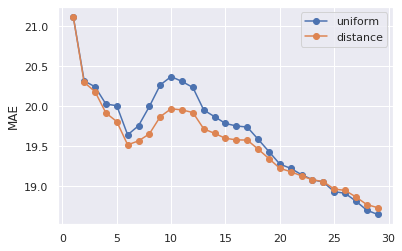

In [14]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

cv = KFold(n_splits = 10, shuffle = False) # 


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(df):
          # División train test aleatoria
          f_train = df.loc[train_fold]
          f_test = df.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(['total_cases'], axis=1), 
                               y = f_train['total_cases'])
          y_pred = knn.predict(X = f_test.drop(['total_cases'], axis = 1))
          # evaluación del modelo
          mae = mean_absolute_error(f_test['total_cases'], y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show() 

In [15]:
#denguetest.reset_index(drop = True, inplace = True)
denguetest1 = denguetest[['reanalysis_min_air_temp_k', 'station_min_temp_c','reanalysis_air_temp_k','weekofyear','year','reanalysis_tdtr_k','station_diur_temp_rng_c','ndvi_ne']]
denguetest1

,reanalysis_min_air_temp_k,station_min_temp_c,reanalysis_air_temp_k,weekofyear,year,reanalysis_tdtr_k,station_diur_temp_rng_c,ndvi_ne
0,296.4,21.7,298.492857,18,2008,3.128571,7.057143,-0.018900
1,296.7,22.2,298.475714,19,2008,2.571429,5.557143,-0.018000
2,296.4,22.8,299.455714,20,2008,4.428571,7.785714,-0.001500
3,296.9,24.4,299.690000,21,2008,4.342857,6.271429,0.126050
4,297.3,23.3,299.780000,22,2008,3.542857,7.085714,0.056800
...,...,...,...,...,...,...,...,...
411,292.7,21.8,297.774286,22,2013,10.100000,9.050000,0.301471
412,291.6,21.4,297.167143,23,2013,9.657143,10.720000,0.247600
413,290.7,21.6,295.831429,24,2013,7.385714,10.075000,0.238729
414,292.5,21.8,295.778571,25,2013,8.228571,8.480000,0.310429


In [16]:
df

,reanalysis_min_air_temp_k,station_min_temp_c,reanalysis_air_temp_k,weekofyear,year,reanalysis_tdtr_k,station_diur_temp_rng_c,ndvi_ne,total_cases
0,295.9,20.0,297.572857,18,1990,2.628571,6.900000,0.122600,4
1,296.4,22.2,298.211429,19,1990,2.371429,6.371429,0.169900,5
2,297.3,22.8,298.781429,20,1990,2.300000,6.485714,0.032250,4
3,297.0,23.3,298.987143,21,1990,2.428571,6.771429,0.128633,3
4,297.5,23.9,299.518571,22,1990,3.014286,9.371429,0.196200,6
...,...,...,...,...,...,...,...,...,...
1451,294.5,22.4,299.334286,21,2010,9.800000,11.933333,0.342750,5
1452,291.9,21.7,298.330000,22,2010,7.471429,10.500000,0.160157,8
1453,292.4,19.2,296.598571,23,2010,7.500000,6.900000,0.247057,1
1454,291.9,21.0,296.345714,24,2010,7.871429,8.733333,0.333914,1


In [ ]:
# constructor
n_neighbors = 29
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit( X = df.drop(['total_cases'], axis=1), y = df['total_cases'])
#y_pred = knn.predict(X = test.drop(['count'], axis = 1))
y_pred = knn.predict(X = denguetest1)
#mae = mean_absolute_error(dtSanJuan['total_cases'], y_pred)
#print ('MAE', mae)


In [18]:
# round the result and cast to int
import numpy as np
from google.colab import files
res = np.rint(y_pred) # round
res = res.astype(int) # cast to int

denguetestOri = denguetest
denguetestOri['total_cases'] = res
outputBoth = pd.DataFrame({ 'city': denguetestOri.city,'year': denguetestOri.year,'weekofyear': denguetestOri.weekofyear, 'total_cases': res})
output = outputBoth
output

,city,year,weekofyear,total_cases
0,sj,2008,18,4
1,sj,2008,19,6
2,sj,2008,20,6
3,sj,2008,21,9
4,sj,2008,22,12
...,...,...,...,...
411,iq,2013,22,3
412,iq,2013,23,3
413,iq,2013,24,2
414,iq,2013,25,2


# Random Forests

In [ ]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for denguejoined in args:
        html_str+=denguejoined.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [20]:
#intento 1
dfrfboth = denguejoined[['reanalysis_min_air_temp_k', 'station_min_temp_c','reanalysis_air_temp_k','weekofyear','year','reanalysis_tdtr_k','station_diur_temp_rng_c','ndvi_ne','total_cases']]
features = ('reanalysis_min_air_temp_k', 'station_min_temp_c','reanalysis_air_temp_k','weekofyear','year','reanalysis_tdtr_k','station_diur_temp_rng_c','ndvi_ne') 
dfrfboth = dfrfboth.interpolate(method ='linear', axis=0)
dfrfboth

,reanalysis_min_air_temp_k,station_min_temp_c,reanalysis_air_temp_k,weekofyear,year,reanalysis_tdtr_k,station_diur_temp_rng_c,ndvi_ne,total_cases
0,295.9,20.0,297.572857,18,1990,2.628571,6.900000,0.122600,4
1,296.4,22.2,298.211429,19,1990,2.371429,6.371429,0.169900,5
2,297.3,22.8,298.781429,20,1990,2.300000,6.485714,0.032250,4
3,297.0,23.3,298.987143,21,1990,2.428571,6.771429,0.128633,3
4,297.5,23.9,299.518571,22,1990,3.014286,9.371429,0.196200,6
...,...,...,...,...,...,...,...,...,...
1451,294.5,22.4,299.334286,21,2010,9.800000,11.933333,0.342750,5
1452,291.9,21.7,298.330000,22,2010,7.471429,10.500000,0.160157,8
1453,292.4,19.2,296.598571,23,2010,7.500000,6.900000,0.247057,1
1454,291.9,21.0,296.345714,24,2010,7.871429,8.733333,0.333914,1


In [21]:
trainrfboth = dfrfboth[dfrfboth['year']<=2007]
testrfboth  = dfrfboth[dfrfboth['year']>2007]
display_side_by_side(trainrfboth.head(),testrfboth.head())


,reanalysis_min_air_temp_k,station_min_temp_c,reanalysis_air_temp_k,weekofyear,year,reanalysis_tdtr_k,station_diur_temp_rng_c,ndvi_ne,total_cases
0,295.9,20.0,297.572857,18,1990,2.628571,6.900000,0.122600,4
1,296.4,22.2,298.211429,19,1990,2.371429,6.371429,0.169900,5
2,297.3,22.8,298.781429,20,1990,2.300000,6.485714,0.032250,4
3,297.0,23.3,298.987143,21,1990,2.428571,6.771429,0.128633,3
4,297.5,23.9,299.518571,22,1990,3.014286,9.371429,0.196200,6
,reanalysis_min_air_temp_k,station_min_temp_c,reanalysis_air_temp_k,weekofyear,year,reanalysis_tdtr_k,station_diur_temp_rng_c,ndvi_ne,total_cases
919,296.6,22.2,298.038571,1,2008,1.842857,5.300000,0.000600,15
920,296.3,21.1,298.142857,2,2008,2.057143,5.014286,-0.008533,14
921,295.3,20.6,297.627143,3,2008,3.000000,5.628571,-0.017667,15
922,296.4,21.1,297.968571,4,2008,2.000000,4.585714,-0.026800,10


In [22]:
# reseteamos el index con el fin de no evitar problemas en la validación cruzada

trainrfboth.reset_index(drop = True, inplace = True)
trainrfboth

,reanalysis_min_air_temp_k,station_min_temp_c,reanalysis_air_temp_k,weekofyear,year,reanalysis_tdtr_k,station_diur_temp_rng_c,ndvi_ne,total_cases
0,295.9,20.0,297.572857,18,1990,2.628571,6.900000,0.122600,4
1,296.4,22.2,298.211429,19,1990,2.371429,6.371429,0.169900,5
2,297.3,22.8,298.781429,20,1990,2.300000,6.485714,0.032250,4
3,297.0,23.3,298.987143,21,1990,2.428571,6.771429,0.128633,3
4,297.5,23.9,299.518571,22,1990,3.014286,9.371429,0.196200,6
...,...,...,...,...,...,...,...,...,...
1304,294.4,22.4,297.880000,48,2007,6.942857,8.350000,0.165640,9
1305,294.3,22.8,298.520000,49,2007,8.300000,10.000000,0.299371,23
1306,294.3,22.6,299.048571,50,2007,9.914286,10.250000,0.313833,28
1307,293.3,22.4,297.141429,51,2007,5.685714,9.000000,0.269800,26


###1. Parametrización

Existen diferentes parámetros que se pueden optimizar para la utilización de RandomForests,  en este caso vamos a ceñirnos a a optimizar el número de estimadores que vamos a probar con distintas potencias de 2


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
No handles with labels found to put in legend.


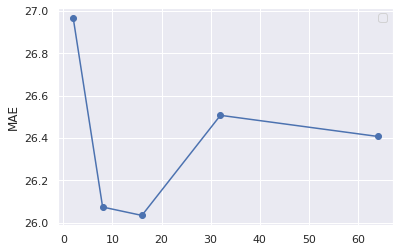

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

cv = KFold(n_splits = 10, shuffle = False, random_state=0) # 

l_estimators = [2, 8, 16, 32, 64]# , 128, 256, 512, 1024]

trainrfboth.isnull().sum()

total_scores = []
for estimators in l_estimators:
   fold_accuracy = []
   regressor =  RandomForestRegressor(n_estimators= estimators, 
                  criterion='mae', random_state=0)
   for train_fold, test_fold in cv.split(trainrfboth):
      # División train test aleatoria
      f_train = trainrfboth.loc[train_fold]
      f_test = trainrfboth.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop(['total_cases'], axis=1),y = f_train['total_cases'])
      y_pred = regressor.predict(X = f_test.drop(['total_cases'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['total_cases'], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


  
plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')      
    

plt.legend()
plt.show() 



In [26]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

Min Value (estimators = 16, MAE =  26.04)


### 2. Construcción y ejecución del modelo 



Una vez que hemos identificado la mejor parametrización vamos a pasar a hacer una ejecución del modelo y vamos graficar sus resultados.

Recordamos que al final del paso 1 hemos dividido en entrenamiento/tuneado y test

Posteriormente, vamos a ejecutar el modelo con la mejor parametrización que hayamos obtenido anteriormente 

In [27]:
# constructor
regressor =  RandomForestRegressor(n_estimators= best_est, criterion='mae', 
                                   random_state=0)
# fit and predict

regressor.fit( X = trainrfboth.drop(['total_cases'], axis=1), y = trainrfboth['total_cases'])
y_pred = regressor.predict(X = testrfboth.drop(['total_cases'], axis = 1))
mae = mean_absolute_error(testrfboth['total_cases'], y_pred)
print ('MAE', mae)



MAE 7.295068027210885


Por último probamos visualizamos como ha quedado nuestra predicción con la realidad.

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


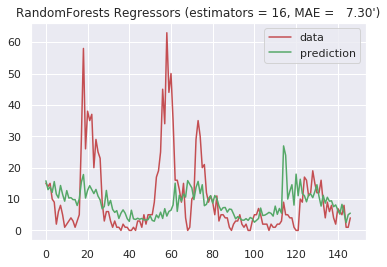

In [28]:

from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(testrfboth['total_cases'].shape[0]))
plt.plot(xx, testrfboth['total_cases'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressors (estimators = %i, MAE = %6.2f')" % (best_est, mae))

plt.show()

In [29]:
# FEATURE RELEVANCIES
print ('Feature Relevancies')
pd.DataFrame({'Attributes': features ,
              'Decision Tree': regressor.feature_importances_})

Feature Relevancies


,Attributes,Decision Tree
0,reanalysis_min_air_temp_k,0.071839
1,station_min_temp_c,0.040108
2,reanalysis_air_temp_k,0.113071
3,weekofyear,0.190127
4,year,0.310691
5,reanalysis_tdtr_k,0.089151
6,station_diur_temp_rng_c,0.086083
7,ndvi_ne,0.098930


#### Boosting

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor



# Fit regression model
regressors = []
regressors.append(DecisionTreeRegressor(max_depth=10, criterion='mae'))
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_regression.html#
regressors.append(AdaBoostRegressor(DecisionTreeRegressor(max_depth=10, criterion='mae'), n_estimators=16, random_state=0))
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py                         
regressors.append(GradientBoostingRegressor(n_estimators=16, learning_rate=0.25, random_state=0, loss='ls'))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


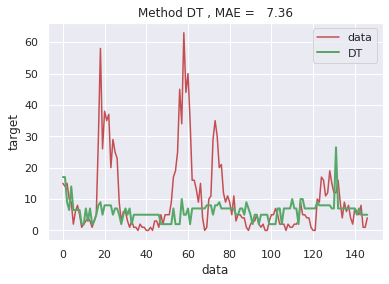

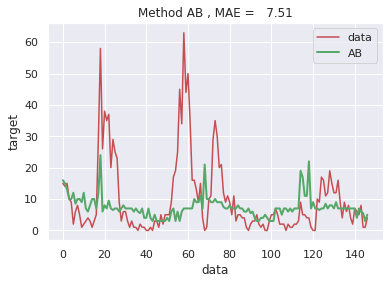

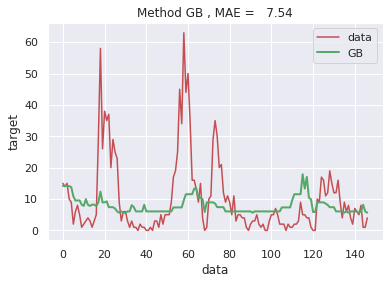

In [31]:
xx = np.stack(i for i in range(len(testrfboth['total_cases'])))
regr_names = ["DT", "AB", "GB"]

results = pd.DataFrame()
results['real'] = testrfboth['total_cases']
               
for i, r in enumerate(regressors):
    r.fit( X = trainrfboth.drop(['total_cases'], axis=1), y = trainrfboth['total_cases'])
    y = r.predict(X = testrfboth.drop(['total_cases'], axis = 1))
    results[regr_names[i]] = y
    mae = mean_absolute_error(testrfboth['total_cases'],y)
    # Plot the results
    plt.figure()
    plt.plot(xx, testrfboth['total_cases'], c='r', label='data')
    plt.plot(xx, y, c="g", label=regr_names[i], linewidth=2)
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("Method %s , MAE = %6.2f" % (regr_names[i], mae ))
    plt.axis('tight')
    plt.legend()
    plt.show()

Observamos que el DT da los mejores resultados, por lo que lo usaremos para la predicción de la competencia

In [32]:
finalRegresor = regressors[0]

# fit and predict
finalRegresor.fit( X = dfrfboth.drop(['total_cases'], axis=1), y = dfrfboth['total_cases'])
testrfboth = denguetest[['reanalysis_min_air_temp_k', 'station_min_temp_c','reanalysis_air_temp_k','weekofyear','year','reanalysis_tdtr_k','station_diur_temp_rng_c','ndvi_ne']]
y_pred = regressor.predict(X = testrfboth)
res = np.rint(y_pred) # round
res = res.astype(int) # cast to int

outputRfBoth = pd.DataFrame({ 'city': denguetest.city,'year': denguetest.year,'weekofyear': denguetest.weekofyear, 'total_cases': res})
outputRfBoth


,city,year,weekofyear,total_cases
0,sj,2008,18,6
1,sj,2008,19,7
2,sj,2008,20,8
3,sj,2008,21,8
4,sj,2008,22,9
...,...,...,...,...
411,iq,2013,22,6
412,iq,2013,23,3
413,iq,2013,24,4
414,iq,2013,25,3


#Salida Final

In [ ]:
with open('submission_format.csv', 'w') as f:
  outputRfBoth.to_csv(f,  index = False)
files.download('submission_format.csv')